In [ ]:
!git clone https://github.com/nishchaybhutoria/CS203-Lab07

In [2]:
%cd CS203-Lab07

/teamspace/studios/this_studio/CS203-Lab07


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
!pwd

/teamspace/studios/this_studio/CS203-Lab07


In [4]:
import matplotlib.pyplot as plt
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
from torchsummary import summary

%matplotlib inline

In [5]:
writer = SummaryWriter("runs/cs203lab07")

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

Device: cuda
PyTorch Version: 2.2.1+cu121
CUDA Available: True
CUDA Version: 12.1
1
NVIDIA L4


In [6]:
train_d1 = pd.read_csv('data/train.tsv', sep='\t', header=None)
test_d1 = pd.read_csv('data/test.tsv', sep='\t', header=None)
train_d2 = pd.read_csv('data/IMDB-Dataset.csv').head(100)

train_d1, val_d1 = train_test_split(train_d1, test_size=0.2, random_state=42)
train_d2, val_d2 = train_test_split(train_d2, test_size=0.2, random_state=42)

display(train_d1.shape, val_d1.shape, test_d1.shape, train_d2.shape, val_d2.shape)
display(train_d1.head(), val_d1.head(), train_d2.head(), val_d2.head())

vectorizer = CountVectorizer(max_features=768)
d1_bow_train = vectorizer.fit_transform(train_d1[0])

d1_bow_val = vectorizer.transform(val_d1[0])
d1_bow_test = vectorizer.transform(test_d1[0])
d2_bow_train = vectorizer.transform(train_d2["review"])
d2_bow_val = vectorizer.transform(val_d2["review"])

d1_bow_train = torch.tensor(d1_bow_train.toarray(), dtype=torch.float32)
d1_bow_val = torch.tensor(d1_bow_val.toarray(), dtype=torch.float32)
d2_bow_train = torch.tensor(d2_bow_train.toarray(), dtype=torch.float32)
d2_bow_val = torch.tensor(d2_bow_val.toarray(), dtype=torch.float32)

d1_train_y = torch.tensor(train_d1[1].values, dtype=torch.long)
d1_val_y = torch.tensor(val_d1[1].values, dtype=torch.long)

d2_train_y = torch.tensor(train_d2["sentiment"].apply(lambda x: 1 if x == "positive" else 0).values, dtype=torch.long)
d2_val_y = torch.tensor(val_d2["sentiment"].apply(lambda x: 1 if x == "positive" else 0).values, dtype=torch.long)

display(d2_train_y, d2_val_y)

print(f"Dataset 1 (Train) BoW Shape: {d1_bow_train.shape}")
print(f"Dataset 1 (Val) BoW Shape: {d1_bow_val.shape}")
print(f"Dataset 1 (Test) BoW Shape: {d1_bow_test.shape}")
print(f"IMDB (Train) BoW Shape: {d2_bow_train.shape}")
print(f"IMDB (Val) BoW Shape: {d2_bow_val.shape}")

(5536, 2)

(1384, 2)

(1821, 2)

(80, 2)

(20, 2)

,0,1
4457,graphic sex may be what 's attracting audience...,1
2471,perhaps the grossest movie ever made,0
26,"the film is moody , oozing , chilling and hear...",1
4828,watching the chemistry between freeman and jud...,1
63,the wonderfully lush morvern callar is pure pu...,1


,0,1
468,overly melodramatic,0
1956,lrb westbrook rrb makes a wonderful subject fo...,1
800,mama africa pretty much delivers on that promise,1
6474,"sad nonsense , this",0
2389,easily the most thoughtful fictional examinati...,1


,review,sentiment
55,As someone has already mentioned on this board...,negative
88,"Nicholas Walker is Paul, the local town Revera...",negative
26,"""The Cell"" is an exotic masterpiece, a dizzyin...",positive
42,"Of all the films I have seen, this one, The Ra...",negative
69,This film laboured along with some of the most...,negative


,review,sentiment
83,"""Fate"" leads Walter Sparrow to come in possess...",negative
53,I cannot believe I enjoyed this as much as I d...,positive
70,Caddyshack Two is a good movie by itself but c...,negative
45,"As a disclaimer, I've seen the movie 5-6 times...",positive
44,"This movie struck home for me. Being 29, I rem...",positive


tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 1])

tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1])

Dataset 1 (Train) BoW Shape: torch.Size([5536, 768])
Dataset 1 (Val) BoW Shape: torch.Size([1384, 768])
Dataset 1 (Test) BoW Shape: (1821, 768)
IMDB (Train) BoW Shape: torch.Size([80, 768])
IMDB (Val) BoW Shape: torch.Size([20, 768])


In [7]:
MODEL = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
embedding_model = AutoModel.from_pretrained(MODEL).to(device)
display(embedding_model.config.hidden_size)

768

In [8]:
def get_batch_embeddings(batch_texts):
    inputs = tokenizer(
        batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512
    ).to(device)

    with torch.inference_mode():
        outputs = embedding_model(**inputs)

    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

def generate_embeddings(texts, batch_size=8):
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        batch_embeddings = get_batch_embeddings(batch_texts)
        embeddings.extend(batch_embeddings)

    return torch.tensor(np.array(embeddings), dtype=torch.float32)

d1_bert_train = generate_embeddings(train_d1[0].tolist())
d1_bert_val = generate_embeddings(val_d1[0].tolist())

d2_bert_train = generate_embeddings(train_d2["review"].tolist())
d2_bert_val = generate_embeddings(val_d2["review"].tolist())

display(d1_bert_train.shape, d1_bert_val.shape, d2_bert_train.shape, d2_bert_val.shape)

torch.Size([5536, 768])

torch.Size([1384, 768])

torch.Size([80, 768])

torch.Size([20, 768])

In [9]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8

train_d1_bow = TensorDataset(d1_bow_train, d1_train_y)
val_d1_bow = TensorDataset(d1_bow_val, d1_val_y)
train_d2_bow = TensorDataset(d2_bow_train, d2_train_y)
val_d2_bow = TensorDataset(d2_bow_val, d2_val_y)

train_d1_bert = TensorDataset(d1_bert_train, d1_train_y)
val_d1_bert = TensorDataset(d1_bert_val, d1_val_y)
train_d2_bert = TensorDataset(d2_bert_train, d2_train_y)
val_d2_bert = TensorDataset(d2_bert_val, d2_val_y)

train_d1_bow_loader = DataLoader(train_d1_bow, batch_size=batch_size, shuffle=True, pin_memory=True)
val_d1_bow_loader = DataLoader(val_d1_bow, batch_size=batch_size, shuffle=False, pin_memory=True)
train_d2_bow_loader = DataLoader(train_d2_bow, batch_size=batch_size, shuffle=True, pin_memory=True)
val_d2_bow_loader = DataLoader(val_d2_bow, batch_size=batch_size, shuffle=False, pin_memory=True)

train_d1_bert_loader = DataLoader(train_d1_bert, batch_size=batch_size, shuffle=True, pin_memory=True)
val_d1_bert_loader = DataLoader(val_d1_bert, batch_size=batch_size, shuffle=False, pin_memory=True)
train_d2_bert_loader = DataLoader(train_d2_bert, batch_size=batch_size, shuffle=True, pin_memory=True)
val_d2_bert_loader = DataLoader(val_d2_bert, batch_size=batch_size, shuffle=False, pin_memory=True)

In [10]:
criterion = nn.CrossEntropyLoss()

def train(model, optimizer, train_loader, val_loader, epochs=10, emb='bow', mode='reg', writer=None):
    model.train()

    train_loss_ = []
    val_loss_ = []
    train_acc_ = []
    val_acc_ = []

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc, val_loss = evaluate(model, val_loader)

        if writer is not None:
            writer.add_scalar(f"Loss/{emb}_{mode}/Train", total_loss / len(train_loader), epoch + 1)
            writer.add_scalar(f"Loss/{emb}_{mode}/Validation", val_loss, epoch + 1)
            writer.add_scalar(f"Accuracy/{emb}_{mode}/Train", train_acc, epoch + 1)
            writer.add_scalar(f"Accuracy/{emb}_{mode}/Validation", val_acc, epoch + 1)

            for name, param in model.named_parameters():
                if param.requires_grad:
                    writer.add_scalar(f"Gradients/{emb}_{mode}/{name}", param.grad.norm(), epoch + 1)
                    break  # Avoid logging every parameter (reduces spam)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        train_loss_.append(total_loss)
        val_loss_.append(val_loss)
        train_acc_.append(train_acc)
        val_acc_.append(val_acc)

    # Plot Loss Curve
    plt.plot(np.arange(epochs), train_loss_, c='b', label='Training Loss')
    plt.plot(np.arange(epochs), val_loss_, c='r', label='Validation Loss')
    plt.title(f'Loss vs Epochs with {emb} Embeddings in {mode} Mode')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy Curve
    plt.plot(np.arange(epochs), train_acc_, c='b', label='Training Accuracy')
    plt.plot(np.arange(epochs), val_acc_, c='r', label='Validation Accuracy')
    plt.title(f'Accuracy vs Epochs with {emb} Embeddings in {mode} Mode')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    
    with torch.inference_mode():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    return correct / total, total_loss / len(loader)

def evaluate_with_confusion_matrix(model, loader):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.inference_mode():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    return cm, y_true, y_pred

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

In [11]:
model_bow = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 2),
).to(device)

model_bert = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 2),
).to(device)

summary(model_bow, (768,))
summary(model_bert, (768,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         393,728
              ReLU-2                  [-1, 512]               0
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 2]             130
Total params: 566,338
Trainable params:

Training MLP on BoW (Dataset 1)


Epoch 1/10 | Train Loss: 425.4689 | Train Acc: 0.6656 | Val Loss: 0.5221 | Val Acc: 0.7334
Epoch 2/10 | Train Loss: 326.6179 | Train Acc: 0.7737 | Val Loss: 0.5212 | Val Acc: 0.7442
Epoch 3/10 | Train Loss: 214.6045 | Train Acc: 0.8607 | Val Loss: 0.6321 | Val Acc: 0.7406
Epoch 4/10 | Train Loss: 88.8079 | Train Acc: 0.9429 | Val Loss: 1.2830 | Val Acc: 0.7247
Epoch 5/10 | Train Loss: 44.7296 | Train Acc: 0.9747 | Val Loss: 1.5734 | Val Acc: 0.7312
Epoch 6/10 | Train Loss: 24.1538 | Train Acc: 0.9828 | Val Loss: 1.9710 | Val Acc: 0.7348
Epoch 7/10 | Train Loss: 25.4747 | Train Acc: 0.9839 | Val Loss: 1.6630 | Val Acc: 0.7298
Epoch 8/10 | Train Loss: 17.2315 | Train Acc: 0.9875 | Val Loss: 2.0425 | Val Acc: 0.7211
Epoch 9/10 | Train Loss: 20.1120 | Train Acc: 0.9874 | Val Loss: 2.2875 | Val Acc: 0.7146
Epoch 10/10 | Train Loss: 20.2610 | Train Acc: 0.9868 | Val Loss: 1.4783 | Val Acc: 0.7110


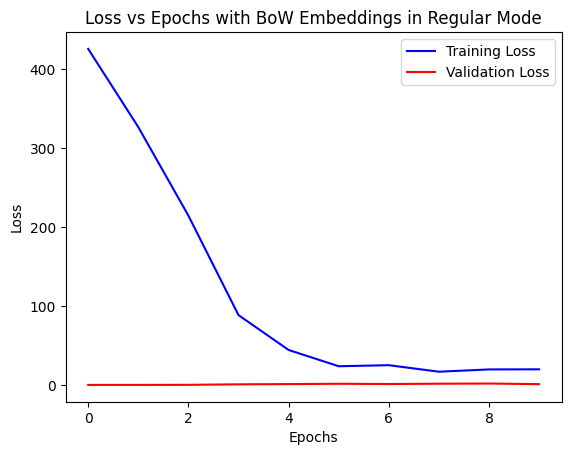

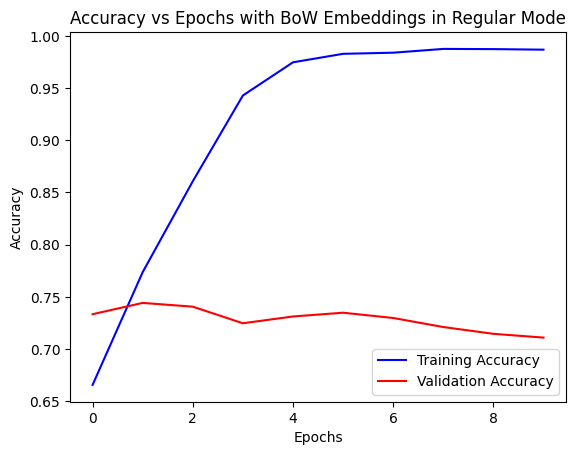

Training MLP on BERT (Dataset 1)
Epoch 1/10 | Train Loss: 301.2800 | Train Acc: 0.7944 | Val Loss: 0.3057 | Val Acc: 0.8642
Epoch 2/10 | Train Loss: 234.3896 | Train Acc: 0.8559 | Val Loss: 0.2998 | Val Acc: 0.8649
Epoch 3/10 | Train Loss: 215.0698 | Train Acc: 0.8658 | Val Loss: 0.3855 | Val Acc: 0.8309
Epoch 4/10 | Train Loss: 204.1532 | Train Acc: 0.8750 | Val Loss: 0.3201 | Val Acc: 0.8649
Epoch 5/10 | Train Loss: 188.6903 | Train Acc: 0.8831 | Val Loss: 0.3086 | Val Acc: 0.8656
Epoch 6/10 | Train Loss: 173.3969 | Train Acc: 0.8965 | Val Loss: 0.3665 | Val Acc: 0.8591
Epoch 7/10 | Train Loss: 152.9973 | Train Acc: 0.9086 | Val Loss: 0.3656 | Val Acc: 0.8678
Epoch 8/10 | Train Loss: 134.3385 | Train Acc: 0.9194 | Val Loss: 0.3539 | Val Acc: 0.8707
Epoch 9/10 | Train Loss: 115.7080 | Train Acc: 0.9317 | Val Loss: 0.3970 | Val Acc: 0.8649
Epoch 10/10 | Train Loss: 95.1002 | Train Acc: 0.9436 | Val Loss: 0.4951 | Val Acc: 0.8454


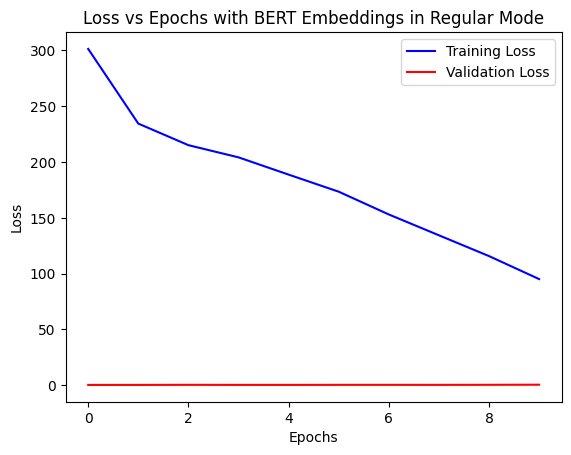

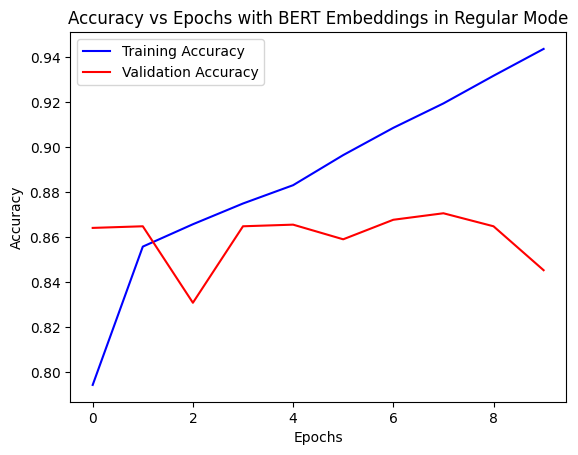

Fine-tuning MLP on BoW (IMDB)
Epoch 1/10 | Train Loss: 27.6665 | Train Acc: 0.7625 | Val Loss: 3.1930 | Val Acc: 0.6500
Epoch 2/10 | Train Loss: 23.4264 | Train Acc: 0.7875 | Val Loss: 3.0216 | Val Acc: 0.6500
Epoch 3/10 | Train Loss: 19.3906 | Train Acc: 0.8125 | Val Loss: 2.8215 | Val Acc: 0.6500
Epoch 4/10 | Train Loss: 15.3253 | Train Acc: 0.8125 | Val Loss: 2.6968 | Val Acc: 0.6500
Epoch 5/10 | Train Loss: 12.1690 | Train Acc: 0.8250 | Val Loss: 2.6232 | Val Acc: 0.6500
Epoch 6/10 | Train Loss: 10.2023 | Train Acc: 0.8625 | Val Loss: 2.5161 | Val Acc: 0.6500
Epoch 7/10 | Train Loss: 8.3062 | Train Acc: 0.8875 | Val Loss: 2.4740 | Val Acc: 0.6500
Epoch 8/10 | Train Loss: 7.1115 | Train Acc: 0.8875 | Val Loss: 2.3590 | Val Acc: 0.7000
Epoch 9/10 | Train Loss: 5.3135 | Train Acc: 0.9000 | Val Loss: 2.2878 | Val Acc: 0.7000
Epoch 10/10 | Train Loss: 4.3871 | Train Acc: 0.9000 | Val Loss: 2.2616 | Val Acc: 0.6500


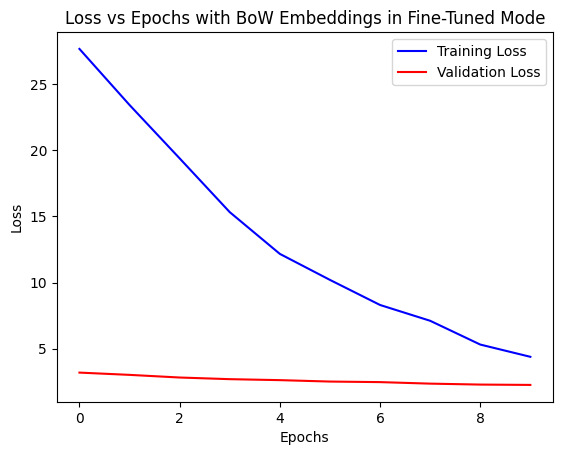

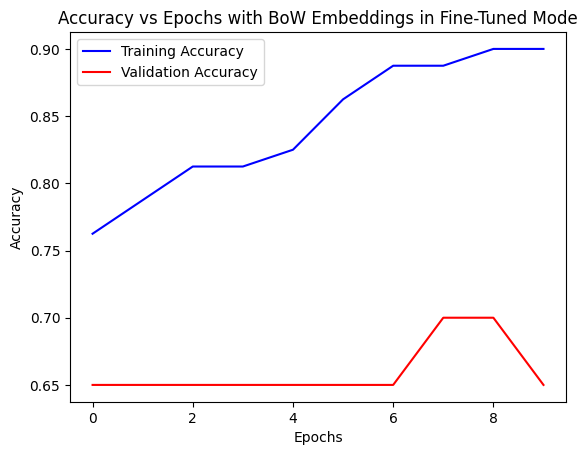

Fine-tuning MLP on BERT (IMDB)
Epoch 1/10 | Train Loss: 3.9305 | Train Acc: 0.8125 | Val Loss: 0.2983 | Val Acc: 0.9000
Epoch 2/10 | Train Loss: 2.7781 | Train Acc: 0.8750 | Val Loss: 0.2545 | Val Acc: 0.9000
Epoch 3/10 | Train Loss: 2.0653 | Train Acc: 0.9125 | Val Loss: 0.2568 | Val Acc: 0.9500
Epoch 4/10 | Train Loss: 1.8290 | Train Acc: 0.9250 | Val Loss: 0.2617 | Val Acc: 0.9500
Epoch 5/10 | Train Loss: 1.6359 | Train Acc: 0.9500 | Val Loss: 0.2645 | Val Acc: 0.9500
Epoch 6/10 | Train Loss: 1.4902 | Train Acc: 0.9500 | Val Loss: 0.2662 | Val Acc: 0.9500
Epoch 7/10 | Train Loss: 1.3710 | Train Acc: 0.9750 | Val Loss: 0.2730 | Val Acc: 0.9000
Epoch 8/10 | Train Loss: 1.2635 | Train Acc: 0.9750 | Val Loss: 0.2777 | Val Acc: 0.9000
Epoch 9/10 | Train Loss: 1.1731 | Train Acc: 0.9750 | Val Loss: 0.2882 | Val Acc: 0.9000
Epoch 10/10 | Train Loss: 1.0894 | Train Acc: 0.9750 | Val Loss: 0.2894 | Val Acc: 0.9000


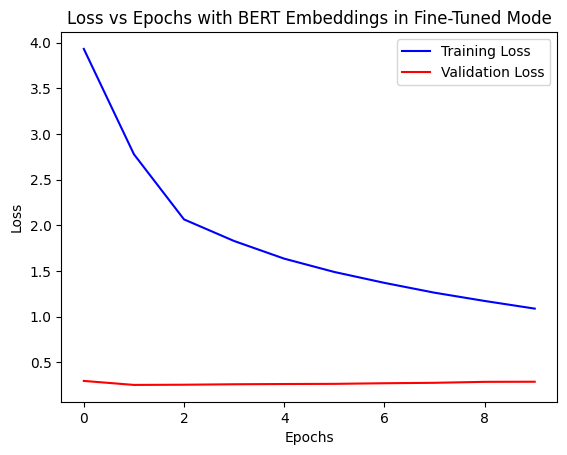

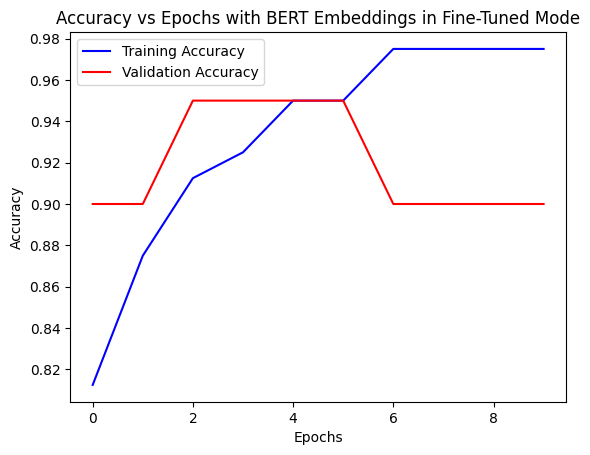

Saved final models


In [12]:
pretrain_lr = 0.001  
finetune_lr = 0.0001  

optimizer_bow = optim.Adam(model_bow.parameters(), lr=pretrain_lr)
optimizer_bert = optim.Adam(model_bert.parameters(), lr=pretrain_lr)

print("Training MLP on BoW (Dataset 1)")
train(model_bow, optimizer_bow, train_d1_bow_loader, val_d1_bow_loader, epochs=10, emb='BoW', mode='Regular', writer=writer)

print("Training MLP on BERT (Dataset 1)")
train(model_bert, optimizer_bert, train_d1_bert_loader, val_d1_bert_loader, epochs=10, emb='BERT', mode='Regular', writer=writer)

with gzip.open("best_model_bow.pt.gz", "wb") as f:
    torch.save(model_bow.state_dict(), f)
with gzip.open("best_model_bert.pt.gz", "wb") as f:
    torch.save(model_bert.state_dict(), f)

with gzip.open("best_model_bow.pt.gz", "rb") as f:
    model_bow.load_state_dict(torch.load(f, weights_only=True))
with gzip.open("best_model_bert.pt.gz", "rb") as f:
    model_bert.load_state_dict(torch.load(f, weights_only=True))

optimizer_bow = optim.Adam(model_bow.parameters(), lr=finetune_lr)
optimizer_bert = optim.Adam(model_bert.parameters(), lr=finetune_lr)

print("Fine-tuning MLP on BoW (IMDB)")
train(model_bow, optimizer_bow, train_d2_bow_loader, val_d2_bow_loader, epochs=10, emb='BoW', mode='Fine-Tuned', writer=writer)

print("Fine-tuning MLP on BERT (IMDB)")
train(model_bert, optimizer_bert, train_d2_bert_loader, val_d2_bert_loader, epochs=10, emb='BERT', mode='Fine-Tuned', writer=writer)

with gzip.open("final_model_bow.pt.gz", "wb") as f:
    torch.save(model_bow.state_dict(), f)
with gzip.open("final_model_bert.pt.gz", "wb") as f:
    torch.save(model_bert.state_dict(), f)

print("Saved final models")

IMDB Validation Results (BoW Model): Accuracy = 0.6500, Loss = 2.2616
IMDB Validation Results (BERT Model): Accuracy = 0.9000, Loss = 0.2894


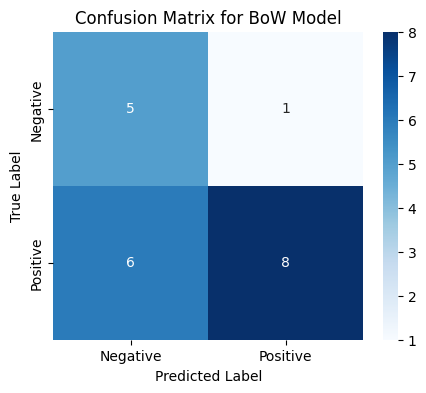

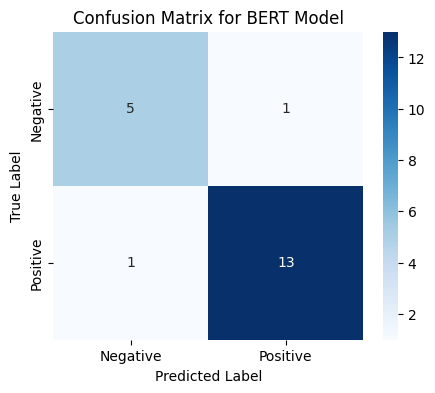

In [13]:
with gzip.open("final_model_bow.pt.gz", "rb") as f:
    model_bow.load_state_dict(torch.load(f, weights_only=True))
with gzip.open("final_model_bert.pt.gz", "rb") as f:
    model_bert.load_state_dict(torch.load(f, weights_only=True))

bow_imdb_val_acc, bow_imdb_val_loss = evaluate(model_bow, val_d2_bow_loader)
bert_imdb_val_acc, bert_imdb_val_loss = evaluate(model_bert, val_d2_bert_loader)

print(f"IMDB Validation Results (BoW Model): Accuracy = {bow_imdb_val_acc:.4f}, Loss = {bow_imdb_val_loss:.4f}")
print(f"IMDB Validation Results (BERT Model): Accuracy = {bert_imdb_val_acc:.4f}, Loss = {bert_imdb_val_loss:.4f}")

bow_cm, bow_y_true, bow_y_pred = evaluate_with_confusion_matrix(model_bow, val_d2_bow_loader)
bert_cm, bert_y_true, bert_y_pred = evaluate_with_confusion_matrix(model_bert, val_d2_bert_loader)

plot_confusion_matrix(bow_cm, "BoW Model")
plot_confusion_matrix(bert_cm, "BERT Model")

In [22]:
print('BoW Model parameters:')
for i, (name, param) in enumerate(model_bow.state_dict().items()):
    print(name, param.shape)
    print(param)

BoW Model parameters:
0.weight torch.Size([512, 768])
tensor([[ 0.0208, -0.0006,  0.0554,  ..., -0.0149,  0.0784, -0.0126],
        [-0.0131,  0.0481, -0.0502,  ..., -0.0258, -0.0122,  0.0102],
        [-0.0470,  0.0448,  0.0101,  ..., -0.0464, -0.0097, -0.0580],
        ...,
        [ 0.0224, -0.0608, -0.0218,  ...,  0.0122,  0.1396, -0.0520],
        [ 0.0101,  0.0488,  0.0576,  ..., -0.0766, -0.0308,  0.0193],
        [-0.0583, -0.0508,  0.0079,  ..., -0.0294,  0.0935,  0.0595]],
       device='cuda:0')
0.bias torch.Size([512])
tensor([-8.1067e-02, -3.5687e-02, -5.3402e-02, -4.6006e-02, -4.0113e-02,
        -1.1694e-01, -1.6691e-01, -1.5801e-01, -1.2131e-01, -7.8436e-02,
        -1.1807e-01, -8.2640e-02, -9.0813e-02, -9.7527e-02, -1.0703e-02,
        -1.7421e-02, -3.7825e-02, -9.2423e-02, -1.3260e-01, -8.5459e-02,
        -5.2113e-02, -9.0825e-02, -9.6645e-02, -1.3368e-01, -7.2379e-02,
        -1.2150e-01, -8.2975e-02,  1.1853e-02, -3.4647e-02, -5.7946e-02,
        -1.8404e-01, -3.5

In [23]:
print('BERT Model parameters:')
for i, (name, param) in enumerate(model_bert.state_dict().items()):
    print(name, param.shape)
    print(param)

BERT Model parameters:
0.weight torch.Size([512, 768])
tensor([[-0.0011, -0.0043,  0.0046,  ..., -0.0238, -0.0336,  0.0086],
        [-0.0201, -0.0304, -0.0335,  ..., -0.0147, -0.0105, -0.0106],
        [ 0.0643, -0.0313,  0.0575,  ..., -0.0505,  0.0488,  0.0548],
        ...,
        [-0.0340, -0.0811, -0.0189,  ..., -0.0994, -0.0237,  0.0067],
        [ 0.0261,  0.0134, -0.0326,  ...,  0.0189, -0.0757, -0.0217],
        [ 0.2251,  0.2061,  0.0465,  ...,  0.0818,  0.0201,  0.0700]],
       device='cuda:0')
0.bias torch.Size([512])
tensor([-2.3845e-02,  5.6483e-03, -6.2027e-03,  2.6188e-02,  2.8607e-02,
        -1.9535e-02,  4.2313e-03, -4.5807e-02,  2.6011e-02, -3.9548e-02,
        -5.6183e-02, -1.4440e-02, -2.0795e-02,  2.2318e-02,  2.3126e-02,
        -3.4065e-02, -3.0458e-02, -4.6851e-02,  2.9092e-02, -4.7647e-02,
        -3.4227e-02,  2.3954e-02, -3.2587e-02, -1.4461e-02,  1.7438e-02,
         9.3638e-03, -8.9707e-03, -1.3093e-02, -3.7845e-02, -1.3277e-02,
         1.0151e-02,  1.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs --bind_all